In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import requests

TRAIN_FILE = "abalone_dataset.csv"
APP_FILE = "abalone_app.csv"
TARGET_COLUMN = "type"

DEV_KEY = "M.L. - Maromba Learning"
URL = "https://aydanomachado.com/mlclass/03_Validation.php"
data = {
    "dev_key": DEV_KEY,
}

def sendData(y_pred):
  data['predictions'] = pd.Series(y_pred).to_json(orient='values')
  r = requests.post(url = URL, data = data)
  print("- Resposta do servidor: \n", r.text, "\n")

In [ ]:
train_df = pd.read_csv(TRAIN_FILE)
app_df = pd.read_csv(APP_FILE)
train_df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,type
0,M,0.535,0.420,0.150,0.6995,0.2575,0.1530,0.2400,3
1,I,0.510,0.380,0.115,0.5155,0.2150,0.1135,0.1660,1
2,I,0.185,0.130,0.045,0.0290,0.0120,0.0075,0.0095,1
3,M,0.550,0.450,0.170,0.8100,0.3170,0.1570,0.2200,3
4,I,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,1


In [ ]:
app_df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,M,0.600,0.480,0.175,1.2290,0.4125,0.2735,0.4150
1,F,0.545,0.385,0.150,1.1185,0.5425,0.2445,0.2845
2,F,0.645,0.520,0.180,1.2850,0.5775,0.3520,0.3170
3,M,0.640,0.510,0.170,1.3715,0.5670,0.3070,0.4090
4,F,0.655,0.540,0.215,1.5555,0.6950,0.2960,0.4440


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3132 non-null   object 
 1   length          3132 non-null   float64
 2   diameter        3132 non-null   float64
 3   height          3132 non-null   float64
 4   whole_weight    3132 non-null   float64
 5   shucked_weight  3132 non-null   float64
 6   viscera_weight  3132 non-null   float64
 7   shell_weight    3132 non-null   float64
 8   type            3132 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 220.3+ KB


<ipython-input-5-bed4e63f21de>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = train_df.corr()


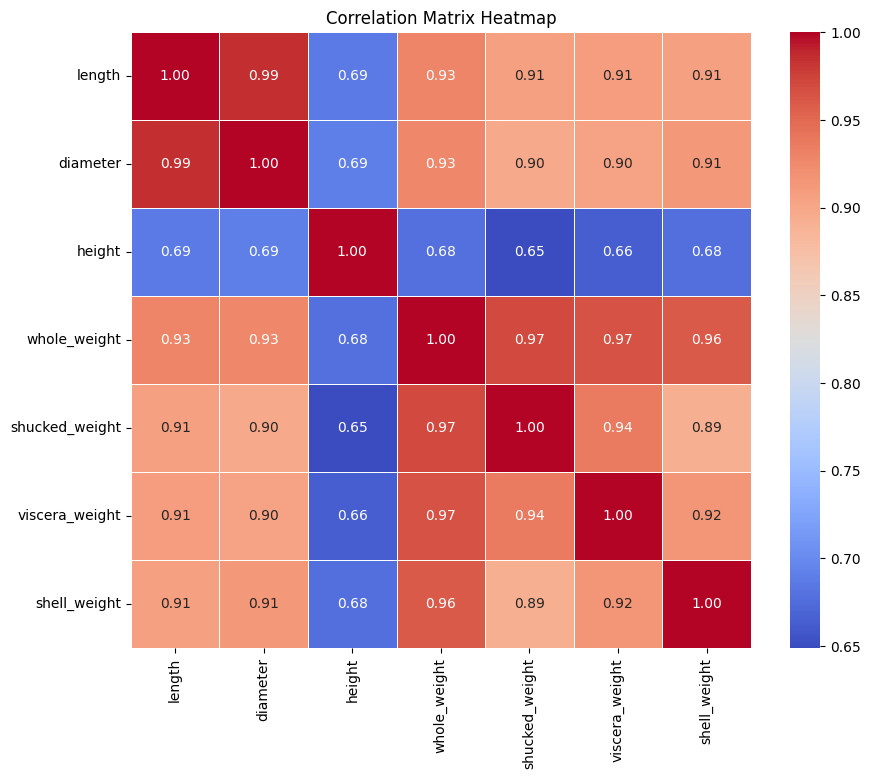

In [ ]:
corrMatrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrMatrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

**Conclusões**:
- Altíssima correlação entre *length* e *diameter*.
- Também entre as features de weight.

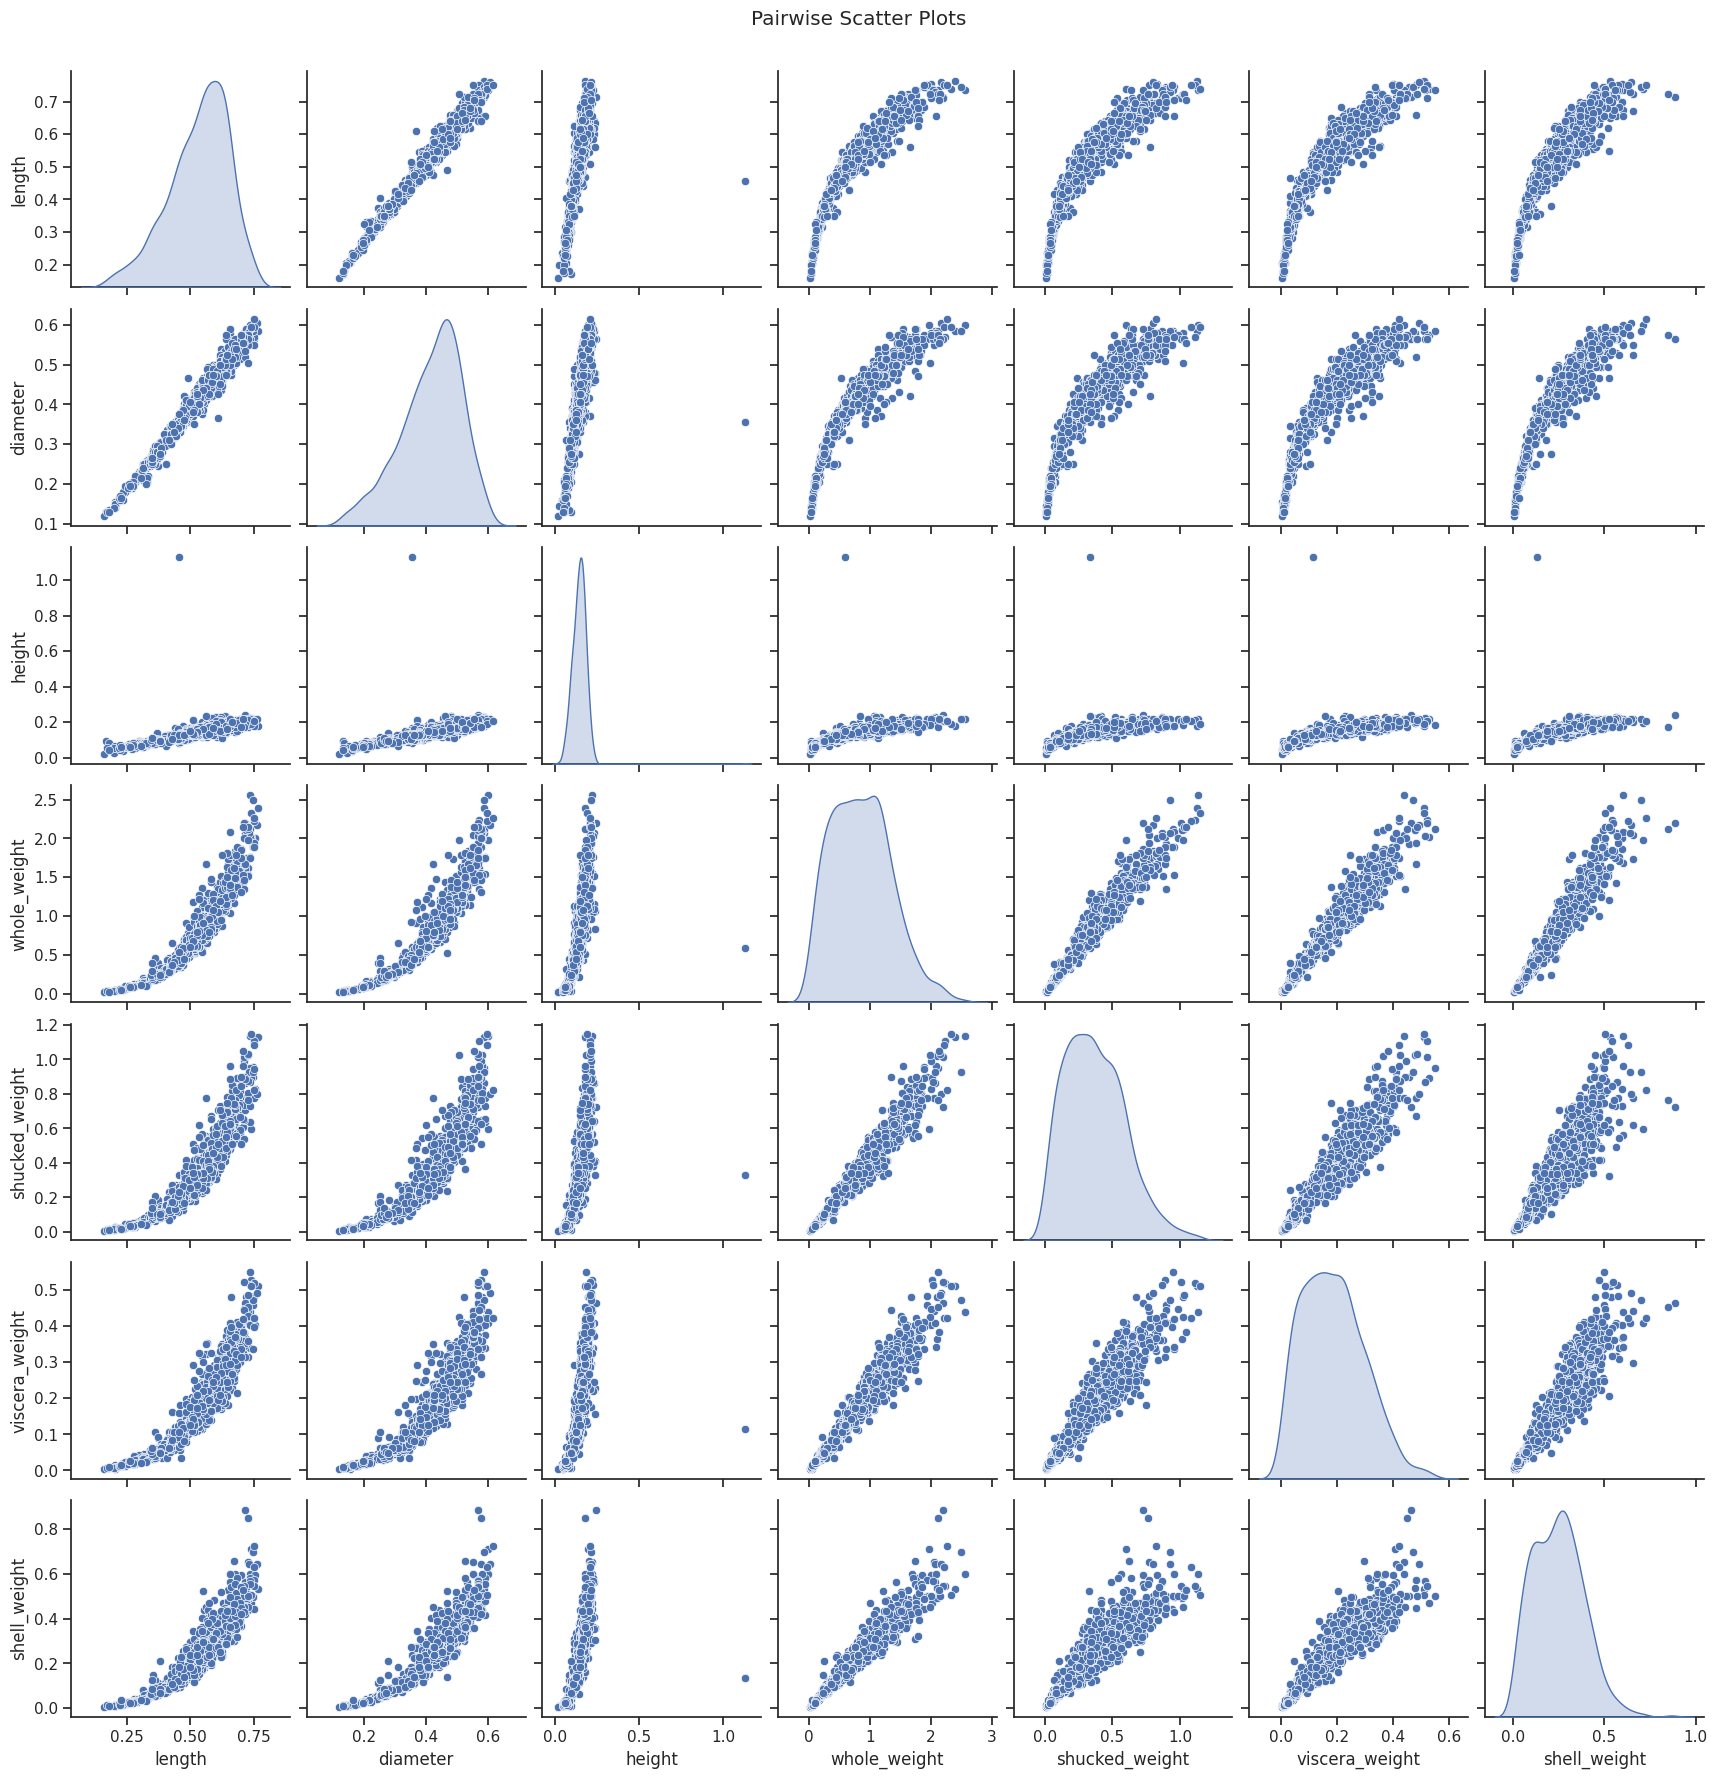

In [ ]:
sns.set(style="ticks")
sns.pairplot(train_df, diag_kind="kde")
plt.suptitle("Pairwise Scatter Plots", y=1.02)
plt.show()

## Pré-processamento

In [ ]:
train_df["sex"].value_counts()

2    1137
1    1042
0     953
Name: sex, dtype: int64

In [ ]:
def convertSexLabel(df):
  le = preprocessing.LabelEncoder()
  df["sex"] = le.fit_transform(df["sex"])

In [ ]:
convertSexLabel(train_df)
convertSexLabel(app_df)
train_df["sex"].value_counts()

2    1137
1    1042
0     953
Name: sex, dtype: int64

In [ ]:
app_df["sex"].value_counts()

2    391
0    354
1    300
Name: sex, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

X = train_df.drop(columns=[TARGET_COLUMN])
# X_scaled = scale(X)
# print(X_scaled.shape)
y = np.array(train_df[[TARGET_COLUMN]], dtype="int").flatten()
# print(y.shape)

def modelsEvaluation(models:dict, folds=10):
  first = True
  best = ""
  kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
  for model in models.keys():
    print(f"\nTesting {model}")
    grid_search = GridSearchCV(models[model]["classifier"],
                               models[model]["param_grid"],
                               cv=kfold, n_jobs=1)
    grid_search.fit(X, y)

    print(f"Best Parameters for {model}: {grid_search.best_params_}")
    print(f"Cross-validated Accuracy: {grid_search.best_score_}")

    models[model]["best_params"] = grid_search.best_params_
    models[model]["acc"] = grid_search.best_score_

    if first or models[model]["acc"] > models[best]["acc"]:
      best = model
      first = False

  return best


In [ ]:
def getModel(func, params):
  model = func(**params)
  model.fit(X, y)
  return model

def getPrediction(model):
  y_pred = model.predict(app_df)
  return y_pred

In [ ]:
from re import M
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "Decision Tree": {
        "classifier": DecisionTreeClassifier(),
        "param_grid": {
            "criterion": ["gini", "entropy", "log_loss"],
            "splitter": ["best", "random"],
            "min_samples_split": [2, 4, 6],
            "max_depth": [2, 4, 6],
        },
        "acc": 0,
    },
    "KNN": {
      "classifier": KNeighborsClassifier(),
      "param_grid": {
          "n_neighbors": [5, 10, 25, 30, 40, 50],
          "weights": ["uniform", "distance"],
      },
      "acc": 0,
    },
    "Random Forest": { "classifier": RandomForestClassifier(),
      "param_grid": {
          "n_estimators": [100, 150, 200, 250],
          "max_depth": [None, 10, 20],
          "criterion": ["gini", "entropy", "log_loss"],
          "min_samples_split": [2, 5, 10],
      },
      "acc": 0,
    },
    "MLP Classifier": {
        "classifier": MLPClassifier(),
        "param_grid": {
          'hidden_layer_sizes': [(100,), (50, 50), (50, 30, 20)],
          'activation': ['relu', 'tanh'],
          'solver': ['adam'],
          'alpha': [0.0001, 0.001, 0.01],
          'learning_rate': ['constant', 'invscaling', 'adaptive'],
          'max_iter': [400, 800, 1200],
          'random_state': [42],
        },
        "acc": 0,
    },
}

best = modelsEvaluation(models)
print(f"Best model: {best}")


Testing Decision Tree
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 'splitter': 'best'}
Cross-validated Accuracy: 0.6273997273152764

Testing Linear Regression
Best Parameters for Linear Regression: {}
Cross-validated Accuracy: 0.4462649348414901

Testing KNN
Best Parameters for KNN: {'n_neighbors': 25, 'weights': 'distance'}
Cross-validated Accuracy: 0.6494322459860402

Testing Random Forest
Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 250}
Cross-validated Accuracy: 0.65294357054191

Testing MLP Classifier
Best Parameters for MLP Classifier: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 30, 20), 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 42, 'solver': 'adam'}
Cross-validated Accuracy: 0.6695356219857145
Best model: MLP Classifier


In [ ]:
modelsToUse = {
    "Decision Tree": DecisionTreeClassifier,
    "Linear Regression": LinearRegression,
    "KNN": KNeighborsClassifier,
    "Random Forest": RandomForestClassifier,
    "MLP Classifier": MLPClassifier,
}

print(f"Best model: {best} | Parameters: {models[best]['best_params']}")
model = getModel(modelsToUse[best], models[best]["best_params"])

y_pred = getPrediction(model)
sendData(y_pred)

Best model: MLP Classifier | Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 30, 20), 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 42, 'solver': 'adam'}
- Resposta do servidor: 
 {"status":"success","dev_key":"M.L. - Maromba Learning","accuracy":0.6679425837320574,"old_accuracy":0} 

